# Import dependencies

In [1]:
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
from torch_geometric.loader import DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from utils.data.load_root import load_root
from utils.evaluation.evaluate_graphs import evaluate_data, evaluate_graphs
from utils.data.build_graph import build_graphs
from utils.plotting.plot_events import plot_information, plot_event
from utils.data.graphdata import GraphDataset
from utils.models.interaction_network import InteractionNetwork
from utils.training.train import train_model
from utils.evaluation.evaluate_model import evaluate_model


# Import Root data

In [2]:
%%time
load_rootdata = False

if load_rootdata:
    path = "~/Documents/Masterarbeit/Panda_Software/PandaRoot/dev/source/macro/data/evtcomplete"
    raw = load_root(path, showentries=False)
    raw.to_hdf('data/raw.h5', key='df', mode='w')  

else:
    raw = pd.read_hdf('data/raw.h5', 'df')  

CPU times: user 111 ms, sys: 108 ms, total: 219 ms
Wall time: 218 ms


Choose number of events to be analysed

In [3]:
nevents = raw.index.max()
nevents = 100

# Investigate raw data

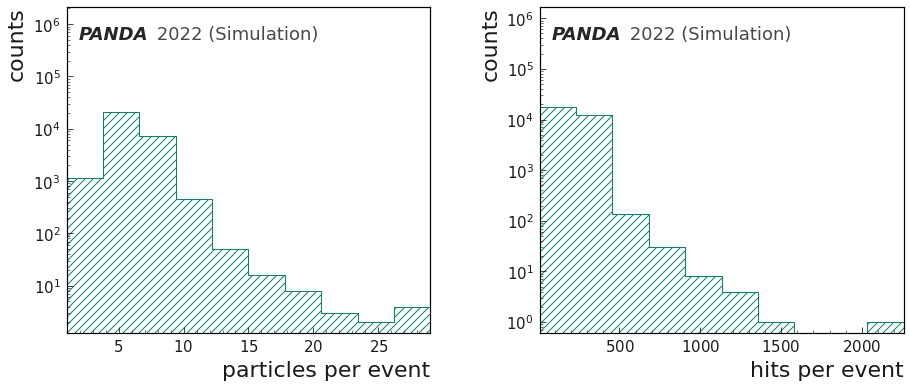

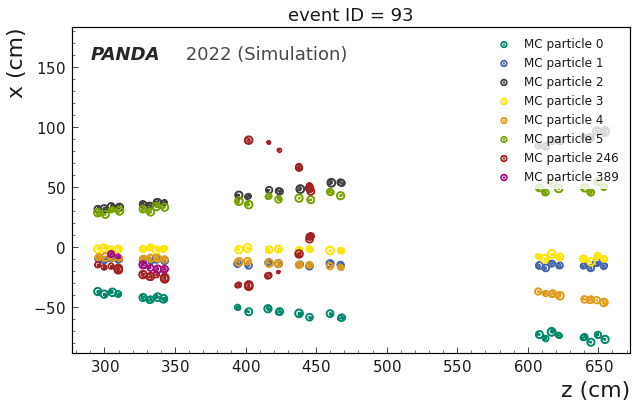

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  6.61it/s]


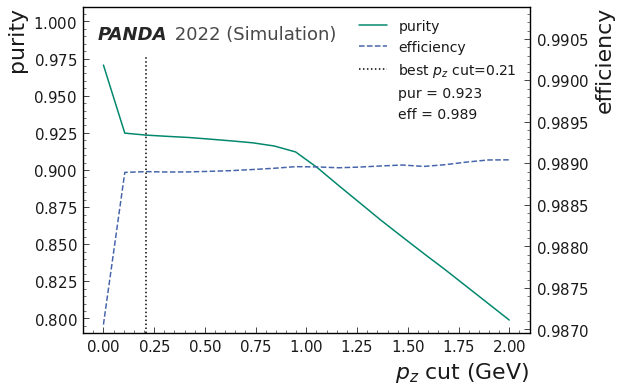

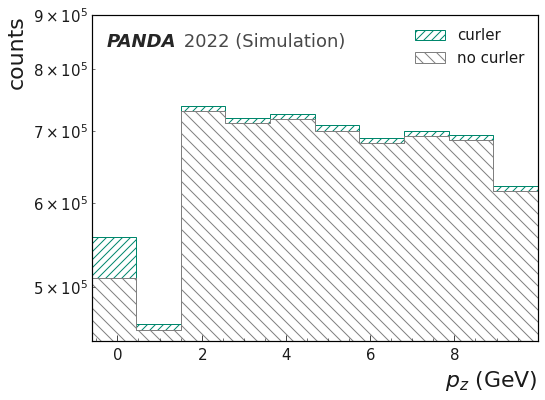

CPU times: user 24.1 s, sys: 1.71 s, total: 25.8 s
Wall time: 24.7 s


In [15]:
%%time

show=True
if show:
   
    plot_information(raw).plot_ntracks_nhits()
    evID=np.random.randint(nevents)
    event = raw.loc[raw.index==evID]
    plot_event(event).plot_eventdisplay()
    
    data_eval = evaluate_data(raw)
    data_eval.plot_pzcut(2)
    data_eval.curler_dist()

# Graph building for training

In [5]:
%%time
data = build_graphs(raw,end=nevents, shuffle=True, remove_duplicates=True)
graphs = data.create_graph_list()

#show preprocessed data
data.events.sort_index()

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 242.69it/s]

CPU times: user 467 ms, sys: 0 ns, total: 467 ms
Wall time: 465 ms


,hit_id,x,z,iso,pz,chamber_id,skewed,particle_id,layer_id,Hit_id,layer,r,theta
event_id,,,,,,,,,,,,,
0,20289,27.522499,309.390015,0.381878,3.068213,1,0,1,7,155,3,310.611766,0.088724
0,7041,70.952499,653.489990,0.451314,7.614493,6,0,2,47,147,23,657.330529,0.108151
0,891,27.522499,437.489990,0.119575,2.421842,4,0,0,25,221,13,438.354856,0.062827
0,15646,20.452499,341.390015,0.382967,2.431979,2,0,0,15,211,7,342.002115,0.059838
0,10554,29.037500,327.769684,0.322732,3.068082,2,0,1,10,158,6,329.053403,0.088360
...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,4609,-102.767502,653.489990,0.059770,9.606862,6,0,0,47,239,23,661.521222,-0.155982
100,886,8.332500,437.489990,0.393287,8.433346,4,0,3,25,121,13,437.569334,0.019044
100,13785,44.187500,327.769684,0.099623,3.149890,2,0,5,10,9,6,330.734789,0.134005


# Evaluate Graph building
for comparison with original raw data choose evaluate_graphs(data.raw.rename(columns={'layer_id':'layer'}), graphs).evaluate_graphs()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:12<00:00,  1.57it/s]


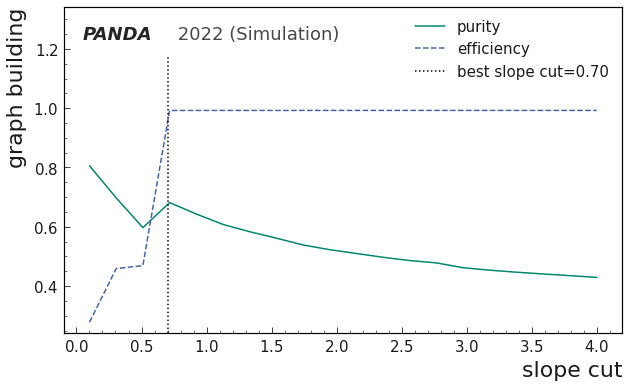

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 52441.78it/s]


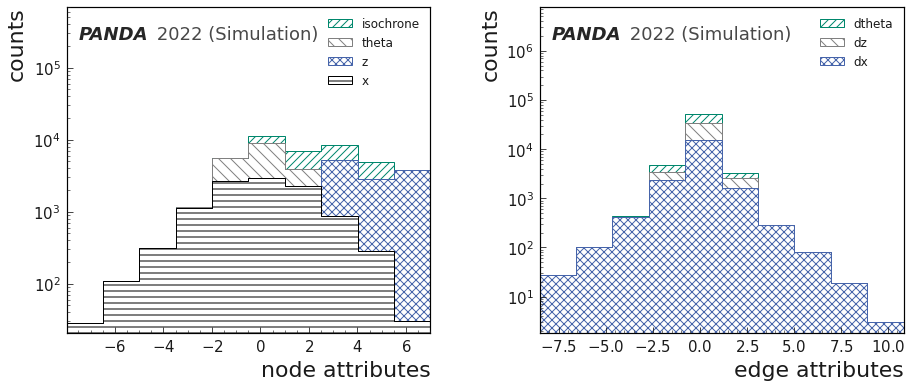

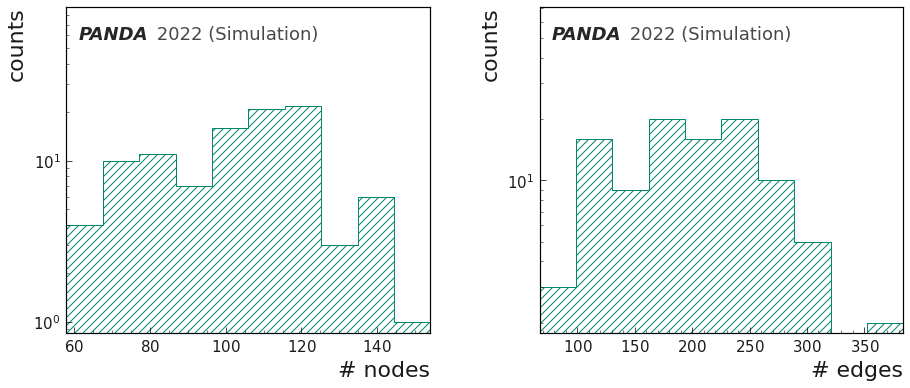

CPU times: user 15 s, sys: 314 ms, total: 15.3 s
Wall time: 14.9 s


In [14]:
%%time
evaluate = True

if evaluate:
    slope = np.linspace(0.1,4,20)
    testdata = build_graphs(raw,end=100, shuffle=True, remove_duplicates=True)

    purities, efficiencies = np.zeros(len(slope)), np.zeros(len(slope))

    for i, s in enumerate(tqdm(slope)):
        testdata.slope = s
        testgraphs = testdata.create_graph_list(show_progress=False)
        purity, efficiency, _ = evaluate_graphs(testdata.events, testgraphs).evaluate_graphs(show_progress=False)
        purities[i] = np.mean(purity)
        efficiencies[i] = np.mean(efficiency)


    plot_information().plot_purity_efficiency(slope, 0.7, purities, efficiencies, 'slope cut', 'graph building')

    plot_information(graphs=graphs).plot_graph_information()

# Plot Graphs

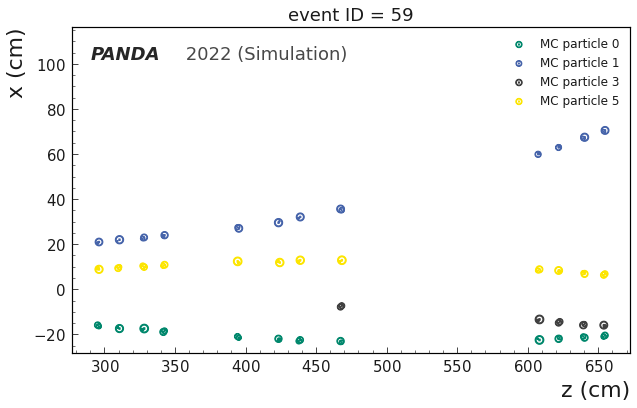

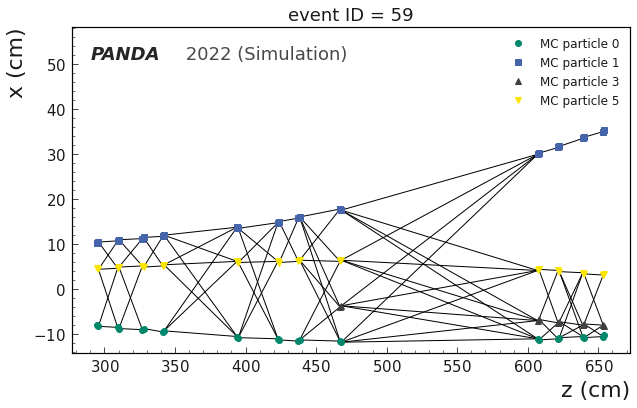

CPU times: user 1.46 s, sys: 241 ms, total: 1.7 s
Wall time: 1.4 s


In [7]:
%%time
evID = np.random.randint(nevents)

hits = data.events.loc[evID]
graph = graphs[evID]

plot_event(hits).plot_eventdisplay()
plot_event(graph=graph).plot_graphdisplay()



# Prepare Training

In [8]:
torch.manual_seed(42)
device = torch.device('cpu')
hidden_size = 30
lr = 0.01
gamma = 0.7
epochs = 3
patience = 5
parts = [0.8, 0.1, 0.1] #sizes of training, validation and testing samples

parts = np.cumsum((nevents*np.array(parts)).astype(int))
partition = {'train': graphs[:parts[0]],  
             'test':  graphs[parts[0]:parts[1]],
             'val': graphs[parts[1]:parts[2]]}

params = {'batch_size': 1, 'shuffle': True, 'num_workers': 6}
train_set = GraphDataset(partition['train'])
train_loader = DataLoader(train_set, **params)
test_set = GraphDataset(partition['test'])
test_loader = DataLoader(test_set, **params)
val_set = GraphDataset(partition['val'])
val_loader = DataLoader(val_set, **params)

In [9]:
model = InteractionNetwork(node_indim=4, edge_indim=3, node_outdim=4, edge_outdim=3, hidden_size=hidden_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=5, gamma=gamma)
patience = 3
model.count_parameters()

+--------------------+------------+
|      Modules       | Parameters |
+--------------------+------------+
| R1.layers.0.weight |    330     |
|  R1.layers.0.bias  |     30     |
| R1.layers.2.weight |    900     |
|  R1.layers.2.bias  |     30     |
| R1.layers.4.weight |     90     |
|  R1.layers.4.bias  |     3      |
| O.layers.0.weight  |    210     |
|  O.layers.0.bias   |     30     |
| O.layers.2.weight  |    900     |
|  O.layers.2.bias   |     30     |
| O.layers.4.weight  |    120     |
|  O.layers.4.bias   |     4      |
| R2.layers.0.weight |    330     |
|  R2.layers.0.bias  |     30     |
| R2.layers.2.weight |    900     |
|  R2.layers.2.bias  |     30     |
| R2.layers.4.weight |     30     |
|  R2.layers.4.bias  |     1      |
+--------------------+------------+
Total Trainable Params: 3998
InteractionNetwork()


# Training

In [10]:
results = train_model(train_loader, val_loader, test_loader, model, optimizer, scheduler, epochs=epochs, patience=patience)

  0%|                                                                                                             | 0/3 [00:00<?, ?it/s]

Train Epoch: 1, epoch time: 0.56s
Mean Train Batch Loss: 0.4940
TPR = 0.5130434782608696, TNR = 0.963963963963964
diff= 0.0040, nbest_disc= 0.6400
mean best disc 0.542


 33%|█████████████████████████████████▋                                                                   | 1/3 [00:00<00:01,  1.01it/s]


Test set: Average loss: 0.0224
, Accuracy: 0.8824

Validation loss decreased (inf --> 0.315042).  Saving model ...
Train Epoch: 2, epoch time: 0.57s
Mean Train Batch Loss: 0.2914
TPR = 0.46258503401360546, TNR = 0.9665071770334929
diff= 0.0168, nbest_disc= 0.4400
mean best disc 0.434


 67%|███████████████████████████████████████████████████████████████████▎                                 | 2/3 [00:01<00:00,  1.02it/s]


Test set: Average loss: 0.0234
, Accuracy: 0.8917

EarlyStopping counter: 1 out of 3
Train Epoch: 3, epoch time: 0.57s
Mean Train Batch Loss: 0.2519
TPR = 0.9478260869565217, TNR = 0.9099099099099099
diff= 0.0379, nbest_disc= 0.8000
mean best disc 0.670


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.03it/s]


Test set: Average loss: 0.0271
, Accuracy: 0.9105

Validation loss decreased (0.315042 --> 0.246372).  Saving model ...


In [11]:
model, losses, accs, disc, test_losses, test_accs = results.trained

# Evaluate Training

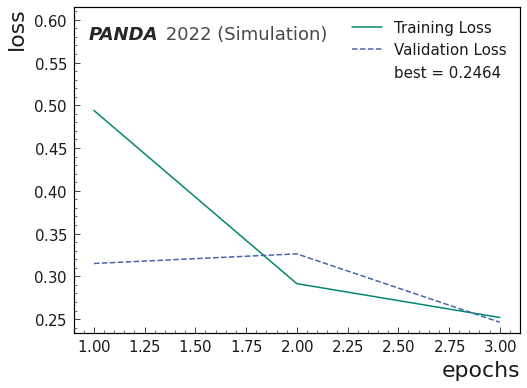

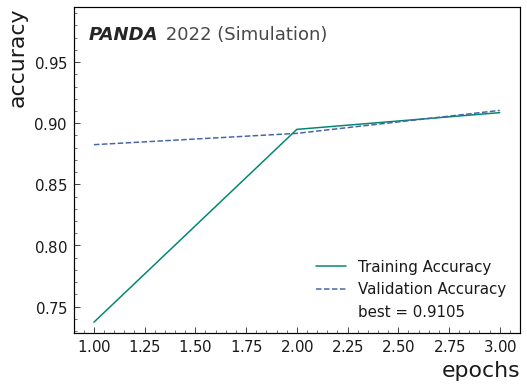

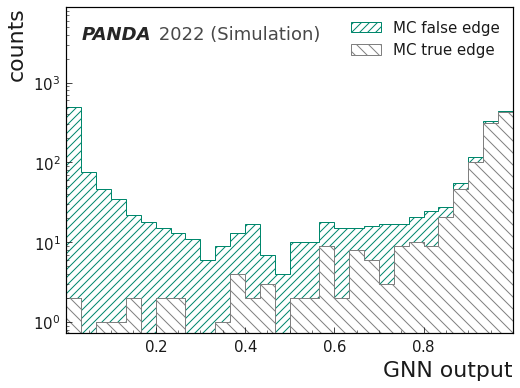

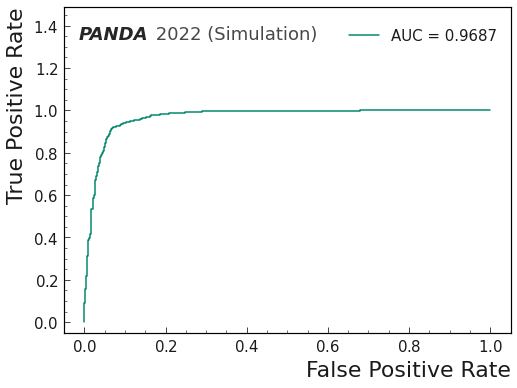

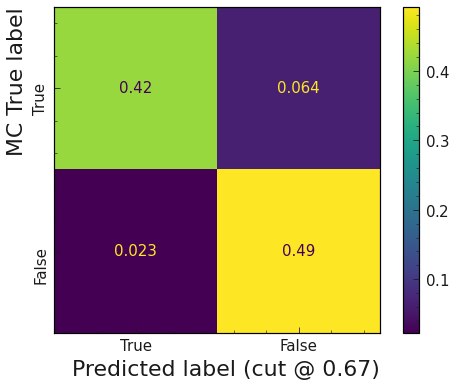

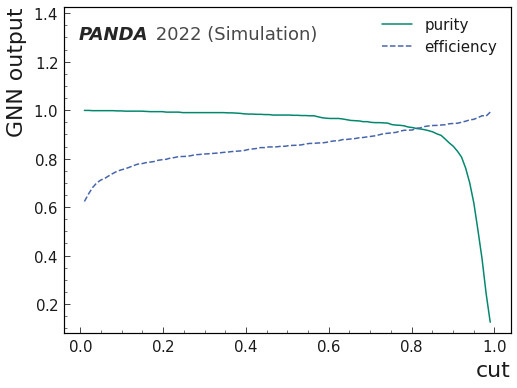

In [12]:
evaluation = evaluate_model('cpu', model, test_loader, losses, test_losses, accs, test_accs, disc, ncuts=100)
evaluation.plot_loss()
evaluation.plot_acc()
evaluation.plot_metrics()

# Show Results

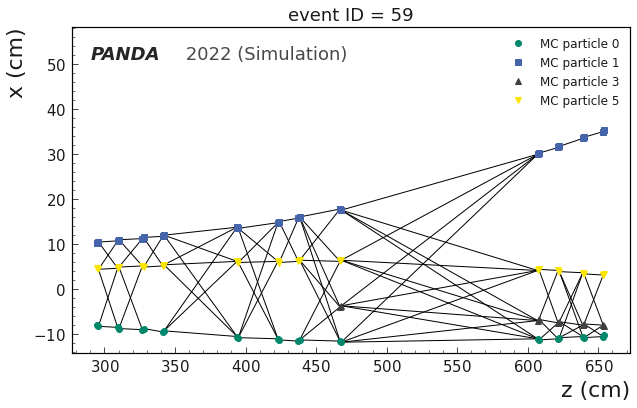

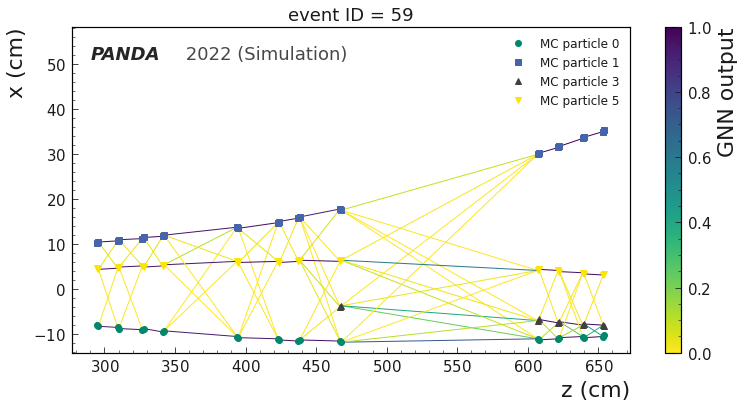

In [13]:
plot_event(hits, graph).plot_graphdisplay()
plot_event(hits, graph).plot_traineddisplay(model)